In [1]:
this_notebook_name = "SagittalSpineSegmentationStudy"

# Update this folder name for your computer

local_data_folder = r"c:\Data\SagittalSpineSegmentationStudy"
overwrite_existing_data_files = False

# All results and output will be archived with this timestamp

import datetime
save_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print("Save timestamp: {}".format(save_timestamp))

# Learning parameters

import numpy as np

ultrasound_size = 128
num_classes = 2
num_epochs = 20
batch_size = 24
max_learning_rate = 0.02
min_learning_rate = 0.00001
regularization_rate = 0.0001
filter_multiplier = 10
WCE_weights = np.array([0.05, 0.95])
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Training data augmentation parameters

max_shift_factor = 0.125
max_rotation_angle = 10
max_zoom_factor = 1.1
min_zoom_factor = 0.8

# Evaluation parameters

acceptable_margin_mm = 1.0
mm_per_pixel = 1.0

roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001,
                  0.0008, 0.0006, 0.0004, 0.0002, 0.0001]

# Uncomment for faster debugging
#roc_thresholds = [0.8, 0.6, 0.4, 0.2, 0.1, 0.01]

# TESTING ONLY: Amount of "leave one out's" to test - Between 0 (don't test any scenarios) and 1 (test all scenarios).
# e.g. training_amounot = 0.50 will test int(0.5 * 8) = 4 of 8 L1OUT models, 0.25 would test int(0.25 * 8) = 2 of 8 models.
# This should be left at 1 unless you want to reduce the number of models run (for testing or debugging).
training_amount = 1.0

Save timestamp: 2019-10-31_12-12-42


In [2]:
import os

from ipywidgets import IntProgress
from IPython.display import display, HTML

import girder_client
import matplotlib.pyplot as plt
import pandas as pd

import keras
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import ultrasound_batch_generator as generator
import sagittal_spine_segmentation_unet as unet
import evaluation_metrics

Using TensorFlow backend.


In [3]:
# Define what data to download

girder_api_url = "https://pocus.cs.queensu.ca/api/v1"

training_ultrasound_ids = [
    "5da9e5c0d9e6a3be02d012b4",
    "5da9e5c7d9e6a3be02d012c6",
    "5da9e5c2d9e6a3be02d012b7",
    "5da9e5c3d9e6a3be02d012ba",
    "5da9e5c8d9e6a3be02d012c9",
    "5da9e5c5d9e6a3be02d012c0",
    "5da9e5c6d9e6a3be02d012c3",
    "5da9e5c4d9e6a3be02d012bd"
]

training_ultrasound_filenames = [
    "q000_ultrasound.npy",
    "q001_ultrasound.npy",
    "q002_ultrasound.npy",
    "q003_ultrasound.npy",
    "q004_ultrasound.npy",
    "q005_ultrasound.npy",
    "q006_ultrasound.npy",
    "q007_ultrasound.npy"
]

training_segmentation_ids = [
    "5da9e5c8d9e6a3be02d012cc",
    "5da9e5ccd9e6a3be02d012de",
    "5da9e5c9d9e6a3be02d012cf",
    "5da9e5cad9e6a3be02d012d2",
    "5da9e5cdd9e6a3be02d012e1",
    "5da9e5cbd9e6a3be02d012d8",
    "5da9e5cbd9e6a3be02d012db",
    "5da9e5cad9e6a3be02d012d5"
]

training_segmentation_filenames = [
    "q000_segmentation.npy",
    "q001_segmentation.npy",
    "q002_segmentation.npy",
    "q003_segmentation.npy",
    "q004_segmentation.npy",
    "q005_segmentation.npy",
    "q006_segmentation.npy",
    "q007_segmentation.npy"
]

testing_ultrasound_filename = "ultrasound-test.npy"
testing_ultrasound_id = "5daa85edd9e6a3be02d012e7"
testing_segmentation_filename = "segmentation-test.npy"
testing_segmentation_id = "5daa85e7d9e6a3be02d012e4"

In [4]:
# These subfolders will be created/populated in the data folder

data_arrays_folder    = "DataArrays"
notebooks_save_folder = "SavedNotebooks"
results_save_folder   = "SavedResults"
models_save_folder    = "SavedModels"
val_data_folder       = "PredictionsValidation"
test_data_folder      = "PredictionsTest"

data_arrays_fullpath = os.path.join(local_data_folder, data_arrays_folder)
notebooks_save_fullpath = os.path.join(local_data_folder, notebooks_save_folder)
results_save_fullpath = os.path.join(local_data_folder, results_save_folder)
models_save_fullpath = os.path.join(local_data_folder, models_save_folder)
val_data_fullpath = os.path.join(local_data_folder, val_data_folder)
test_data_fullpath = os.path.join(local_data_folder, test_data_folder)

if not os.path.exists(data_arrays_fullpath):
    os.makedirs(data_arrays_fullpath)
    print("Created folder: {}".format(data_arrays_fullpath))

if not os.path.exists(notebooks_save_fullpath):
    os.makedirs(notebooks_save_fullpath)
    print("Created folder: {}".format(notebooks_save_fullpath))

if not os.path.exists(results_save_fullpath):
    os.makedirs(results_save_fullpath)
    print("Created folder: {}".format(results_save_fullpath))

if not os.path.exists(models_save_fullpath):
    os.makedirs(models_save_fullpath)
    print("Created folder: {}".format(models_save_fullpath))

if not os.path.exists(val_data_fullpath):
    os.makedirs(val_data_fullpath)
    print("Created folder: {}".format(val_data_fullpath))

if not os.path.exists(test_data_fullpath):
    os.makedirs(test_data_fullpath)
    print("Created folder: {}".format(test_data_fullpath))


In [5]:
# Download data from Girder

time_download_start = datetime.datetime.now()

print("Downloading training files ...")

n_files = len(training_ultrasound_ids)

f = IntProgress(min=0, max=n_files*2)
display(f)

gclient = girder_client.GirderClient(apiUrl=girder_api_url)

for i in range(n_files):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_ultrasound_filenames[i])
    if not os.path.exists(ultrasound_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(ultrasound_fullname))
        gclient.downloadFile(training_ultrasound_ids[i], ultrasound_fullname)
    f.value = i * 2 + 1
    
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_segmentation_filenames[i])
    if not os.path.exists(segmentation_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(segmentation_fullname))
        gclient.downloadFile(training_segmentation_ids[i], segmentation_fullname)
    f.value = i * 2 + 2

test_ultrasound_fullname = os.path.join(data_arrays_fullpath, testing_ultrasound_filename)
if not os.path.exists(test_ultrasound_fullname):
    print("Downloading {}...".format(test_ultrasound_fullname))
    gclient.downloadFile(testing_ultrasound_id, test_ultrasound_fullname)

test_segmentation_fullname = os.path.join(data_arrays_fullpath, testing_segmentation_filename)
if not os.path.exists(test_segmentation_fullname) or overwrite_existing_data_files:
    print("Downloading {}...".format(test_segmentation_fullname))
    gclient.downloadFile(testing_segmentation_id, test_segmentation_fullname)
    
time_download_stop = datetime.datetime.now()
print("\nTotal download time: {}".format(time_download_stop - time_download_start))

IntProgress(value=0, max=16)


Total download time: 0:00:00.010971


In [6]:
# Read data into numpy arrays

ultrasound_arrays = []
segmentation_arrays = []

f = IntProgress(min=0, max=n_files * 2)
display(f)

time_start = datetime.datetime.now()

for i in range(n_files):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_ultrasound_filenames[i])
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_segmentation_filenames[i])

    ultrasound_data = np.load(ultrasound_fullname)
    f.value = i * 2 + 1
    
    segmentation_data = np.load(segmentation_fullname)
    f.value = i * 2 + 2
    
    ultrasound_arrays.append(ultrasound_data)
    segmentation_arrays.append(segmentation_data)

test_ultrasound_fullname = os.path.join(data_arrays_fullpath, testing_ultrasound_filename)
test_ultrasound_array = np.load(test_ultrasound_fullname)

test_segmentation_fullname = os.path.join(data_arrays_fullpath, testing_segmentation_filename)
test_segmentation_array = np.load(test_segmentation_fullname)
    
time_stop = datetime.datetime.now()
print("\nTotal time to load from files: {}".format(time_stop - time_start))

IntProgress(value=0, max=16)


Total time to load from files: 0:00:00.104730


Timestamp for saved files: 2019-10-31_12-12-42

Training parameters
Number of epochs:    20
Step size maximum:   0.02
Step size decay:     0.0009995
Batch size:          24
Regularization rate: 0.0001

Saving validation predictions in: c:\Data\SagittalSpineSegmentationStudy\PredictionsValidation
Saving test predictions in:       c:\Data\SagittalSpineSegmentationStudy\PredictionsTest
Saving models in:                 c:\Data\SagittalSpineSegmentationStudy\SavedModels

*** Leave-one-out round # 0

Training on 2767 images, validating on 523 images...
Epoch 1/20


c:\D\te1\lib\site-packages\scipy\ndimage\interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


115/115 [==============================] - 9s 81ms/step - loss: 0.0110 - acc: 0.9621 - dice_coef: 0.9767 - val_loss: 0.0024 - val_acc: 0.9755 - val_dice_coef: 0.5169
Epoch 2/20
115/115 [==============================] - 7s 62ms/step - loss: 0.0042 - acc: 0.9872 - dice_coef: 0.9927 - val_loss: 0.0022 - val_acc: 0.9903 - val_dice_coef: 0.5068
Epoch 3/20
115/115 [==============================] - 7s 62ms/step - loss: 0.0034 - acc: 0.9881 - dice_coef: 0.9933 - val_loss: 0.0036 - val_acc: 0.9943 - val_dice_coef: 0.5055
Epoch 4/20
115/115 [==============================] - 7s 62ms/step - loss: 0.0031 - acc: 0.9886 - dice_coef: 0.9936 - val_loss: 0.0015 - val_acc: 0.9858 - val_dice_coef: 0.5074
Epoch 5/20
115/115 [==============================] - 7s 63ms/step - loss: 0.0030 - acc: 0.9887 - dice_coef: 0.9937 - val_loss: 0.0018 - val_acc: 0.9904 - val_dice_coef: 0.5060
Epoch 6/20
115/115 [==============================] - 7s 61ms/step - loss: 0.0028 - acc: 0.9891 - dice_coef: 0.9940 - val_loss

117/117 [==============================] - 7s 63ms/step - loss: 0.0035 - acc: 0.9886 - dice_coef: 0.9936 - val_loss: 0.0025 - val_acc: 0.9926 - val_dice_coef: 0.5061
Epoch 4/20
117/117 [==============================] - 7s 63ms/step - loss: 0.0032 - acc: 0.9887 - dice_coef: 0.9937 - val_loss: 0.0021 - val_acc: 0.9909 - val_dice_coef: 0.5081
Epoch 5/20
117/117 [==============================] - 7s 63ms/step - loss: 0.0029 - acc: 0.9893 - dice_coef: 0.9941 - val_loss: 0.0014 - val_acc: 0.9853 - val_dice_coef: 0.5080
Epoch 6/20
117/117 [==============================] - 7s 64ms/step - loss: 0.0028 - acc: 0.9893 - dice_coef: 0.9941 - val_loss: 0.0015 - val_acc: 0.9873 - val_dice_coef: 0.5070
Epoch 7/20
117/117 [==============================] - 8s 64ms/step - loss: 0.0026 - acc: 0.9895 - dice_coef: 0.9942 - val_loss: 0.0012 - val_acc: 0.9838 - val_dice_coef: 0.5086
Epoch 8/20
117/117 [==============================] - 7s 64ms/step - loss: 0.0026 - acc: 0.9898 - dice_coef: 0.9943 - val_loss

Epoch 6/20
125/125 [==============================] - 8s 64ms/step - loss: 0.0033 - acc: 0.9889 - dice_coef: 0.9938 - val_loss: 0.0021 - val_acc: 0.9905 - val_dice_coef: 0.5067
Epoch 7/20
125/125 [==============================] - 8s 63ms/step - loss: 0.0030 - acc: 0.9890 - dice_coef: 0.9939 - val_loss: 0.0024 - val_acc: 0.9940 - val_dice_coef: 0.5047
Epoch 8/20
125/125 [==============================] - 8s 64ms/step - loss: 0.0027 - acc: 0.9891 - dice_coef: 0.9941 - val_loss: 0.0014 - val_acc: 0.9841 - val_dice_coef: 0.5071
Epoch 9/20
125/125 [==============================] - 8s 63ms/step - loss: 0.0026 - acc: 0.9890 - dice_coef: 0.9941 - val_loss: 0.0017 - val_acc: 0.9900 - val_dice_coef: 0.5052
Epoch 10/20
125/125 [==============================] - 8s 63ms/step - loss: 0.0025 - acc: 0.9892 - dice_coef: 0.9943 - val_loss: 0.0020 - val_acc: 0.9921 - val_dice_coef: 0.5047
Epoch 11/20
125/125 [==============================] - 8s 63ms/step - loss: 0.0025 - acc: 0.9891 - dice_coef: 0.99

122/122 [==============================] - 8s 64ms/step - loss: 0.0024 - acc: 0.9896 - dice_coef: 0.9945 - val_loss: 0.0025 - val_acc: 0.9855 - val_dice_coef: 0.5070
Epoch 9/20
122/122 [==============================] - 8s 64ms/step - loss: 0.0024 - acc: 0.9896 - dice_coef: 0.9945 - val_loss: 0.0016 - val_acc: 0.9766 - val_dice_coef: 0.5082
Epoch 10/20
122/122 [==============================] - 8s 63ms/step - loss: 0.0023 - acc: 0.9898 - dice_coef: 0.9946 - val_loss: 0.0020 - val_acc: 0.9828 - val_dice_coef: 0.5072
Epoch 11/20
122/122 [==============================] - 8s 63ms/step - loss: 0.0023 - acc: 0.9897 - dice_coef: 0.9945 - val_loss: 0.0022 - val_acc: 0.9845 - val_dice_coef: 0.5074
Epoch 12/20
122/122 [==============================] - 8s 65ms/step - loss: 0.0022 - acc: 0.9900 - dice_coef: 0.9948 - val_loss: 0.0019 - val_acc: 0.9824 - val_dice_coef: 0.5078
Epoch 13/20
122/122 [==============================] - 8s 64ms/step - loss: 0.0022 - acc: 0.9900 - dice_coef: 0.9947 - val_

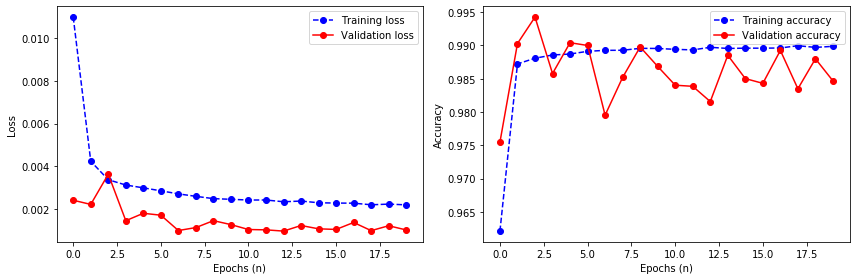

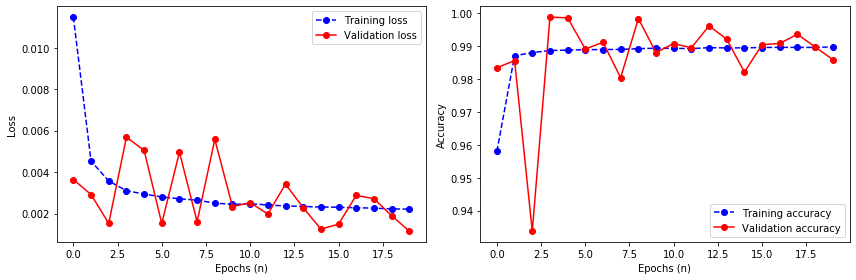

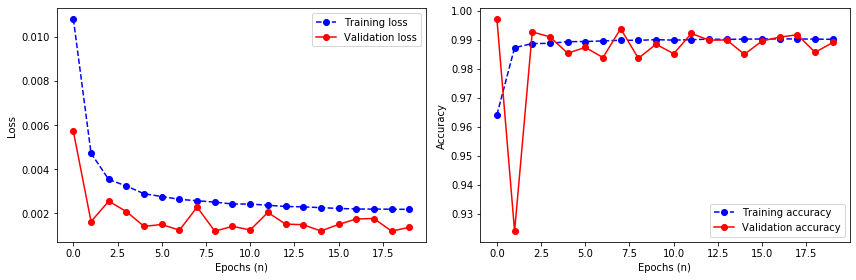

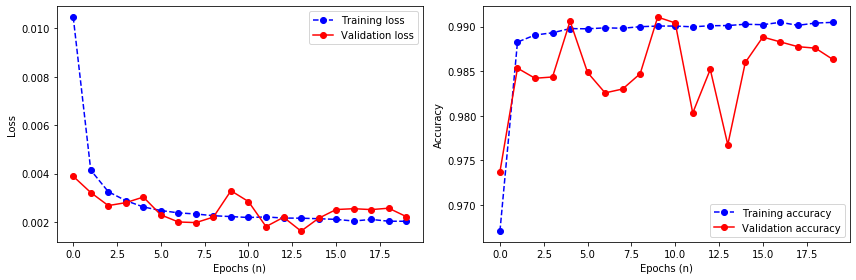

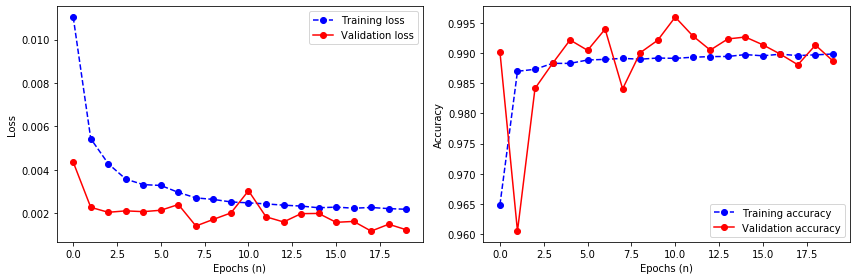

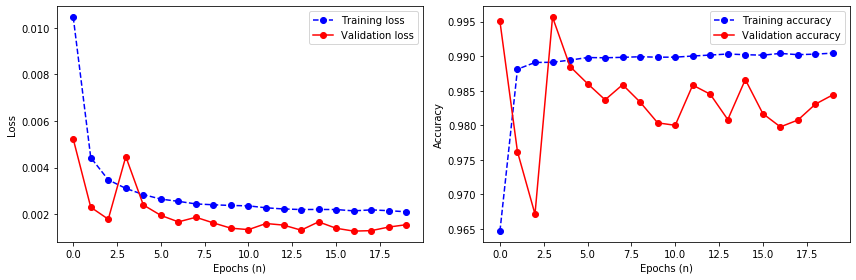

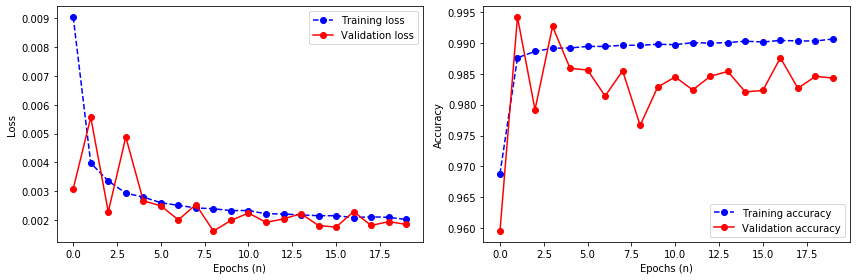

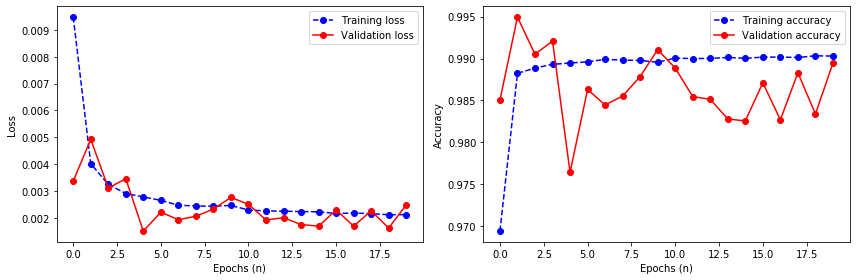

In [7]:
# Print training parameters, to archive them together with the notebook output.

time_sequence_start = datetime.datetime.now()

print("Timestamp for saved files: {}".format(save_timestamp))
print("\nTraining parameters")
print("Number of epochs:    {}".format(num_epochs))
print("Step size maximum:   {}".format(max_learning_rate))
print("Step size decay:     {}".format(learning_rate_decay))
print("Batch size:          {}".format(batch_size))
print("Regularization rate: {}".format(regularization_rate))
print("")
print("Saving validation predictions in: {}".format(val_data_fullpath))
print("Saving test predictions in:       {}".format(test_data_fullpath))
print("Saving models in:                 {}".format(models_save_fullpath))

# ROC data will be saved in these containers

val_best_metrics    = dict()
val_fuzzy_metrics   = dict()
val_aurocs          = np.zeros(n_files)
val_best_thresholds = np.zeros(n_files)

test_best_metrics    = dict()
test_fuzzy_metrics   = dict()
test_aurocs          = np.zeros(n_files)
test_best_thresholds = np.zeros(n_files)


for i in range(int(n_files*training_amount)):
    
    # Prepare data arrays
    
    train_ultrasound_data = np.zeros(
        [0, ultrasound_arrays[0].shape[1], ultrasound_arrays[0].shape[2], ultrasound_arrays[0].shape[3]])
    train_segmentation_data = np.zeros(
        [0, ultrasound_arrays[0].shape[1], ultrasound_arrays[0].shape[2], ultrasound_arrays[0].shape[3]])
    
    val_ultrasound_data = ultrasound_arrays[i]
    val_segmentation_data = segmentation_arrays[i]
    val_ultrasound_filename = training_ultrasound_filenames[i]
    
    for train_index in range(n_files):
        if train_index != i:
            train_ultrasound_data = np.concatenate((train_ultrasound_data, ultrasound_arrays[train_index]))
            train_segmentation_data = np.concatenate((train_segmentation_data, segmentation_arrays[train_index]))
    
    n_train = train_ultrasound_data.shape[0]
    n_val = val_ultrasound_data.shape[0]
    
    print("\n*** Leave-one-out round # {}".format(i))
    print("\nTraining on {} images, validating on {} images...".format(n_train, n_val))
    
    # Create and train model
    
    model = unet.sagittal_spine_unet(ultrasound_size, num_classes, filter_multiplier, regularization_rate)
    
    model.compile(
        optimizer=keras.optimizers.adam(lr=max_learning_rate, decay=learning_rate_decay),
        loss=[unet.weighted_categorical_crossentropy(WCE_weights)],
        metrics=["accuracy", unet.dice_coef]
        # metrics=["accuracy"]
    )
        
    #model.summary()
        
    training_generator = generator.UltrasoundSegmentationBatchGenerator(
        train_ultrasound_data,
        train_segmentation_data[:, :, :, 0],
        batch_size,
        (ultrasound_size, ultrasound_size),
        max_shift_factor=max_shift_factor,
        min_zoom_factor=min_zoom_factor,
        max_zoom_factor=max_zoom_factor,
        max_rotation_angle=max_rotation_angle
    )
        
    training_time_start = datetime.datetime.now()
    
    training_log = model.fit_generator(
        training_generator,
        validation_data=(val_ultrasound_data, val_segmentation_data),
        epochs=num_epochs,
        verbose=1
    )
        
    training_time_stop = datetime.datetime.now()
    
    # Pring training log
    
    print("\nMetrics at the end of training")
    print("  val_acc:       {}".format(training_log.history['val_acc'][-1]))
    print("  val loss:      {}".format(training_log.history['val_loss'][-1]))
    # print("  val_dice:      {}".format(training_log.history['val_dice_coef'][-1]))
    print("  Training time: {}".format(training_time_stop-training_time_start))
    
    # Plot training loss and metrics
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    axes[0].plot(training_log.history['loss'], 'bo--')
    axes[0].plot(training_log.history['val_loss'], 'ro-')
    axes[0].set(xlabel='Epochs (n)', ylabel='Loss')
    axes[0].legend(['Training loss', 'Validation loss'])
    
    axes[1].plot(training_log.history['acc'], 'bo--')
    axes[1].plot(training_log.history['val_acc'], 'ro-')
    axes[1].set(xlabel='Epochs (n)', ylabel='Accuracy')
    axes[1].legend(['Training accuracy', 'Validation accuracy'])
    
    fig.tight_layout()
    
    # Predict on validation and test data
    
    y_pred_val  = model.predict(val_ultrasound_data)
    y_pred_test = model.predict(test_ultrasound_array)
    
    # Saving predictions for further evaluation
    
    filename_noext, extension = os.path.splitext(val_ultrasound_filename)
    val_prediction_filename = save_timestamp + "_prediction_" + filename_noext + ".npy"
    val_prediction_fullname = os.path.join(val_data_fullpath, val_prediction_filename)
    np.save(val_prediction_fullname, y_pred_val)
    
    test_prediction_filename = save_timestamp + "_prediction_test.npy"
    test_prediction_fullname = os.path.join(test_data_fullpath, test_prediction_filename)
    np.save(test_prediction_fullname, y_pred_test)
    
    # Archive trained model with unique filename based on notebook name and timestamp
    
    model_file_name = this_notebook_name + "_model-" + str(i) + "_" + save_timestamp + ".h5"
    model_fullname = os.path.join(models_save_fullpath, model_file_name)
    model.save(model_fullname)
    
    # Validation results
    
    vali_metrics_dicts, vali_best_threshold_index, vali_area = evaluation_metrics.compute_roc(
        roc_thresholds, y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)
    
    val_fuzzy_metrics[i] = evaluation_metrics.compute_evaluation_metrics(
        y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)
    
    val_best_metrics[i]    = vali_metrics_dicts[vali_best_threshold_index]
    val_aurocs[i]          = vali_area
    val_best_thresholds[i] = roc_thresholds[vali_best_threshold_index]
    
    # Test results
    
    test_metrics_dicts, test_best_threshold_index, test_area = evaluation_metrics.compute_roc(
        roc_thresholds, y_pred_test, test_segmentation_array, acceptable_margin_mm, mm_per_pixel)
    
    test_fuzzy_metrics[i] = evaluation_metrics.compute_evaluation_metrics(
        y_pred_test, test_segmentation_array, acceptable_margin_mm, mm_per_pixel)
    
    test_best_metrics[i]    = test_metrics_dicts[test_best_threshold_index]
    test_aurocs[i]          = test_area
    test_best_thresholds[i] = roc_thresholds[test_best_threshold_index]
    
    # Printing total time of this validation round
    
    print("\nTotal round time:  {}".format(datetime.datetime.now() - training_time_start))
    print("")


time_sequence_stop = datetime.datetime.now()

print("\nTotal training time:   {}".format(time_sequence_stop - time_sequence_start))


In [8]:
# Arrange results in tables

metric_labels = [
    "AUROC",
    "best thresh",
    "best TP",
    "best FP",
    "best recall",
    "best precis",
    "fuzzy recall",
    "fuzzy precis",
    "fuzzy Fscore"
]

results_labels = []

for label in metric_labels:
    results_labels.append("Vali " + label)

for label in metric_labels:
    results_labels.append("Test " + label)

    
results_df = pd.DataFrame(columns = results_labels)

for i in range(int(n_files*training_amount)):
    results_df.loc[i] = [
        val_aurocs[i],
        val_best_thresholds[i],
        val_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE],
        val_best_metrics[i][evaluation_metrics.FALSE_POSITIVE_RATE],
        val_best_metrics[i][evaluation_metrics.RECALL],
        val_best_metrics[i][evaluation_metrics.PRECISION],
        val_fuzzy_metrics[i][evaluation_metrics.RECALL],
        val_fuzzy_metrics[i][evaluation_metrics.PRECISION],
        val_fuzzy_metrics[i][evaluation_metrics.FSCORE],
        test_aurocs[i],
        test_best_thresholds[i],
        test_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE],
        test_best_metrics[i][evaluation_metrics.FALSE_POSITIVE_RATE],
        test_best_metrics[i][evaluation_metrics.RECALL],
        test_best_metrics[i][evaluation_metrics.PRECISION],
        test_fuzzy_metrics[i][evaluation_metrics.RECALL],
        test_fuzzy_metrics[i][evaluation_metrics.PRECISION],
        test_fuzzy_metrics[i][evaluation_metrics.FSCORE],
    ]

display(results_df)

print("\nAverages")

results_means_df = results_df.mean()

vali_means_df = pd.DataFrame(results_means_df.loc[:"Vali fuzzy Fscore"])
test_means_df = pd.DataFrame(results_means_df.loc["Test AUROC":])

# display(vali_means_df)

# print(vali_means_df[0]["Vali AUROC"])

means_df = pd.DataFrame(columns=["Validation", "Testing"])
for metric_name in metric_labels:
    means_df.loc[metric_name] = [vali_means_df[0]["Vali " + metric_name], 
                                 test_means_df[0]["Test " + metric_name]]

display(means_df)

,Vali AUROC,Vali best thresh,Vali best TP,Vali best FP,Vali best recall,Vali best precis,Vali fuzzy recall,Vali fuzzy precis,Vali fuzzy Fscore,Test AUROC,Test best thresh,Test best TP,Test best FP,Test best recall,Test best precis,Test fuzzy recall,Test fuzzy precis,Test fuzzy Fscore
0,0.510161,0.9,0.923057,0.001544,0.923057,0.664737,0.768339,0.264017,0.392994,0.499206,0.70,0.636415,0.004682,0.636415,0.376412,0.585390,0.177094,0.271924
1,0.508498,0.9,0.840348,0.001121,0.840348,0.639238,0.691148,0.199926,0.310139,0.510680,0.90,0.838442,0.002391,0.838442,0.524857,0.715575,0.188340,0.298195
2,0.504944,0.9,0.828074,0.000566,0.828074,0.749255,0.668831,0.283035,0.397751,0.504821,0.90,0.760590,0.001118,0.760590,0.637263,0.659268,0.222513,0.332726
3,0.504372,0.8,0.781257,0.002275,0.781257,0.639212,0.661420,0.334827,0.444591,0.503592,0.80,0.767344,0.002969,0.767344,0.496563,0.669788,0.251952,0.366164
4,0.504918,0.8,0.815660,0.001562,0.815660,0.616115,0.669947,0.254493,0.368865,0.497396,0.55,0.523263,0.005716,0.523263,0.319340,0.495861,0.174560,0.258218
5,0.508106,0.9,0.882809,0.001042,0.882809,0.724851,0.713763,0.289940,0.412370,0.496565,0.60,0.536194,0.003303,0.536194,0.438004,0.506069,0.247723,0.332625
6,0.506817,0.9,0.853002,0.000980,0.853002,0.752278,0.703090,0.322354,0.442041,0.498855,0.80,0.614547,0.001962,0.614547,0.538222,0.569552,0.260070,0.357087
7,0.502116,0.8,0.707446,0.001082,0.707446,0.753790,0.609533,0.402394,0.484763,0.497014,0.55,0.517297,0.003510,0.517297,0.432375,0.492054,0.265490,0.344892



Averages


,Validation,Testing
AUROC,0.506242,0.501016
best thresh,0.862500,0.725000
best TP,0.828957,0.649262
best FP,0.001271,0.003206
best recall,0.828957,0.649262
best precis,0.692434,0.470380
fuzzy recall,0.685759,0.586695
fuzzy precis,0.293873,0.223468
fuzzy Fscore,0.406689,0.320229


In [9]:
# Save results table

csv_filename = this_notebook_name + "_" + save_timestamp + ".csv"
csv_fullname = os.path.join(results_save_fullpath, csv_filename)
results_df.to_csv(csv_fullname)

print("Results saved to: {}".format(csv_fullname))

Results saved to: c:\Data\SagittalSpineSegmentationStudy\SavedResults\SagittalSpineSegmentationStudy_2019-10-31_12-12-42.csv


In [10]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

<IPython.core.display.Javascript object>

In [11]:
# Export HTML copy of this notebook

notebook_file_name = this_notebook_name + "_" + save_timestamp + ".html"
notebook_fullname = os.path.join(notebooks_save_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

Notebook saved to: c:\Data\SagittalSpineSegmentationStudy\SavedNotebooks\SagittalSpineSegmentationStudy_2019-10-31_12-12-42.html
